In [1]:
import pickle 
import json
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import torch

from mlflux.predictor import FluxANNs
from mlflux.ann import RealFluxDataset
from mlflux.eval import mse_r2_weighted, distribution_weighted, open_case, evaluate
from mlflux.datafunc import data_split_psd_rand

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


%load_ext autoreload
%autoreload 3

### Uncertainty structure

In [44]:
# "U", "tsea", "tair", "zu", "zt"
from mlflux.utils import qsat

def gen_grid (model):
    U = np.linspace(0,30,201)  # 1D array for U
    Ta = np.linspace(0,20,101)  # 1D array for Ta
    To = np.ones(101)*10 # 1D array for To
    U_grid, Ta_grid = np.meshgrid(U, Ta)
    U_flat = U_grid.flatten().reshape(-1, 1)  # Flatten to 2D column
    Ta_flat = Ta_grid.flatten().reshape(-1, 1)  # Flatten to 2D column
    To_flat = np.ones_like(U_flat) * 10    
    zu_flat = np.ones_like(U_flat) * 10
    zt_flat = np.ones_like(U_flat) * 5
    RH_flat = np.ones_like(U_flat) * 80
    p_flat = np.ones_like(U_flat) * 101000
    # zu_flat = np.ones_like(U_flat) * model.Xscale['mean'][:,5].numpy()
    # zt_flat = np.ones_like(U_flat) * model.Xscale['mean'][:,6].numpy()
    # zq_flat = np.ones_like(U_flat) * model.Xscale['mean'][:,7].numpy()
    if model.config['ikeys'] == ["U", "tsea", "tair", "zu", "zt"]:
        X = np.hstack([U_flat,To_flat,Ta_flat,zu_flat,zt_flat]).astype('float32')
    elif model.config['ikeys'] == ["U", "tsea", "tair", "rh"]:
        X = np.hstack([U_flat,To_flat,Ta_flat,RH_flat]).astype('float32')  
    elif model.config['ikeys'] == ["U", "tsea", "tair", "rh", "p"]:
        X = np.hstack([U_flat,To_flat,Ta_flat,RH_flat,p_flat]).astype('float32')

    mean_pred = model.pred_mean(torch.tensor(X)).detach().numpy()
    mean_2D = mean_pred.reshape(101, 201)
    std_pred = model.pred_var(torch.tensor(X)).detach().numpy()**0.5
    std_2D = std_pred.reshape(101, 201)
    
    return X.reshape(101, 201, -1), mean_2D, std_2D

''' Plot the data density '''
from scipy.stats import gaussian_kde
def plot_data_density (ax, ds, Xgrid):
    vd = RealFluxDataset(ds, input_keys=model.config['ikeys'], 
                         output_keys=model.config['okeys'], bulk_keys=model.config['bkeys'])
    # Weighted
    # w_index = np.random.choice(len(vd.X), 10000, p=vd.W.squeeze()/vd.W.sum())
    # kde = gaussian_kde(np.vstack([vd.X[w_index,0], vd.X[w_index,2]-vd.X[w_index,1]]))
    kde = gaussian_kde(np.vstack([vd.X[:,0], vd.X[:,2]-vd.X[:,1]]), weights=vd.W[:,0])    

    # Not weighted
    U = Xgrid[:,:,0]; Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]
    zi = kde(np.vstack([U.flatten(), Tdiff.flatten()]))  # Evaluate KDE on the grid
    print(U[0,1]-U[0,0])
    print(Tdiff[1,0]-Tdiff[0,0])
    zi = zi.reshape(101, 201)*len(vd.X)*(U[0,1]-U[0,0])*(Tdiff[1,0]-Tdiff[0,0])  # Reshape to match grid, AND! convert density to counts
    levels = (1, 5)
    contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours
    ax.clabel(contour, inline=True, fontsize=10)
    return contour

/state/partition1/job-53233809/ipykernel_2720080/379978406.py:48: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours
/state/partition1/job-53233809/ipykernel_2720080/379978406.py:48: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours
/state/partition1/job-53233809/ipykernel_2720080/379978406.py:48: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours
/state/partition1/job-53233809/ipykernel_2720080/379978406.py:48: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours
/state/partition1/job-53233809/ipykernel_2720080/379978406.py:48: UserWarning: The follo

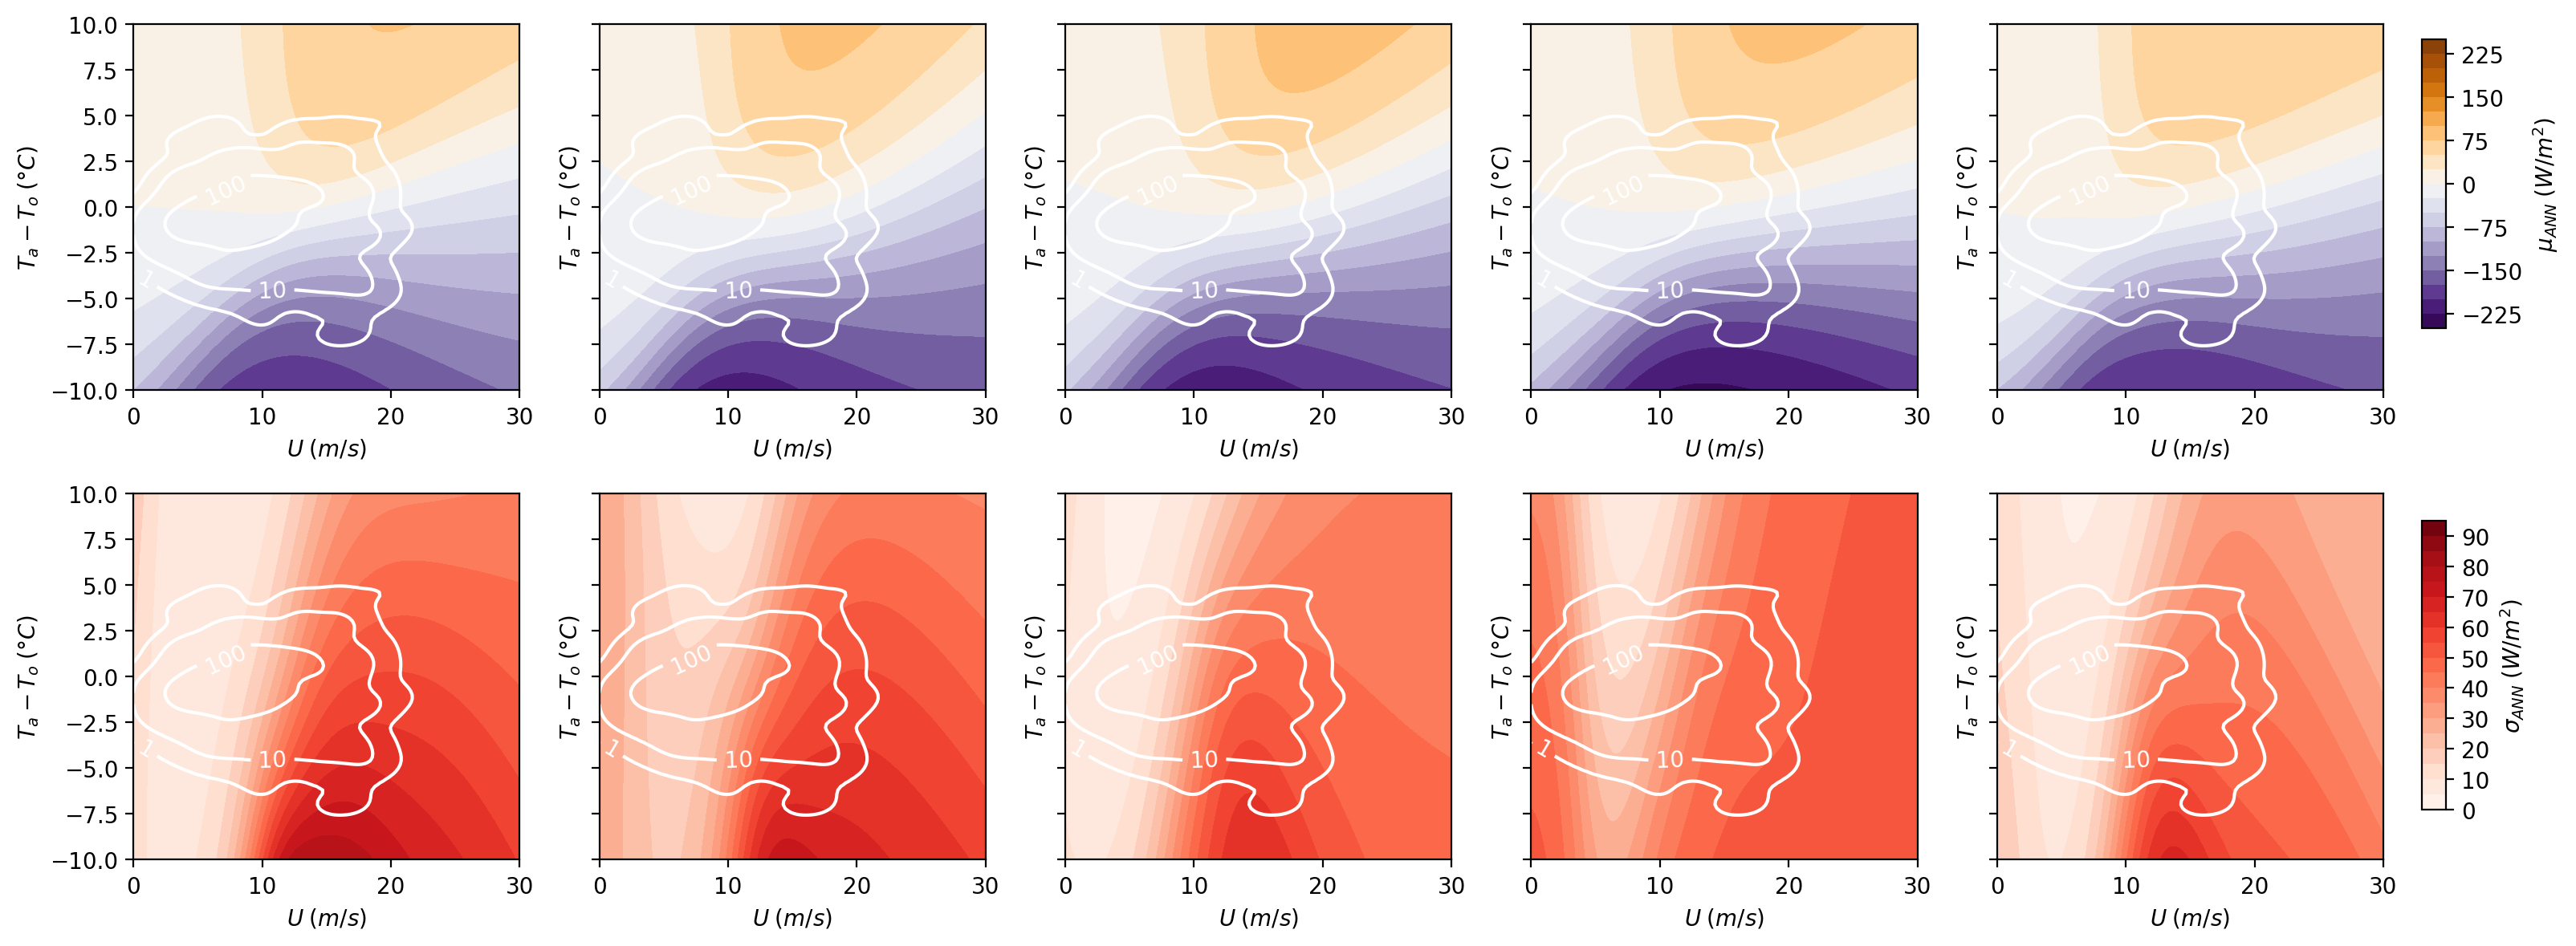

In [3]:
from mlflux.utils import qsat
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_5/tr5_1step/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_5/tr5/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/LH5_1/NW_tr2/'
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/M5_1/NW_tr2/'
fig, axes = plt.subplots(2, 5, figsize=[15,6], dpi=200, sharey=True)

std_2D_ensem = []
mean_2D_ensem = []
for rand_seed in range(5):
    model_name = 'model_rand%g.p' %rand_seed
    model = open_case (model_dir, model_name)
    Xgrid, mean_grid, std_grid = gen_grid (model)
    
    ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
    U = Xgrid[:,:,0]
    Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]

    ax = axes[0,rand_seed]
    img_mean = ax.contourf(U, Tdiff, mean_grid, levels=np.arange(-250,270,25), cmap='PuOr_r')
    # img = plt.contourf(U, Ta-To, std_2D, levels=np.arange(0,200,5), cmap='Reds')
    ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
    ax.set_xlim([0,30]); ax.set_ylim([-10,10])
    mean_2D_ensem.append(mean_grid)
    plot_data_density (ax, ds, Xgrid) 

    ax = axes[1,rand_seed]
    # img = ax.contourf(U, Tdiff, np.log(std_grid), levels=np.arange(1,6.5,0.5), cmap='Reds')
    img_std = ax.contourf(U, Tdiff, std_grid, levels=np.arange(0,100,5), cmap='Reds')
    ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
    ax.set_xlim([0,30]); ax.set_ylim([-10,10])
    std_2D_ensem.append(std_grid)
    plot_data_density (ax, ds, Xgrid)        
       

cbar_ax0 = fig.add_axes([1, 0.65, 0.01, 0.3])  # [left, bottom, width, height]
cbar0 = fig.colorbar(img_mean, cax=cbar_ax0, label=r'$\mu_{ANN} \; (W/m^2)$')

cbar_ax1 = fig.add_axes([1, 0.15, 0.01, 0.3])  # [left, bottom, width, height]
cbar1 = fig.colorbar(img_std, cax=cbar_ax1, label=r'$\sigma_{ANN} \; (W/m^2)$')
plt.tight_layout();

0.15
0.19999981


/state/partition1/job-53233809/ipykernel_2720080/3974038310.py:50: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours


0.15
0.19999981


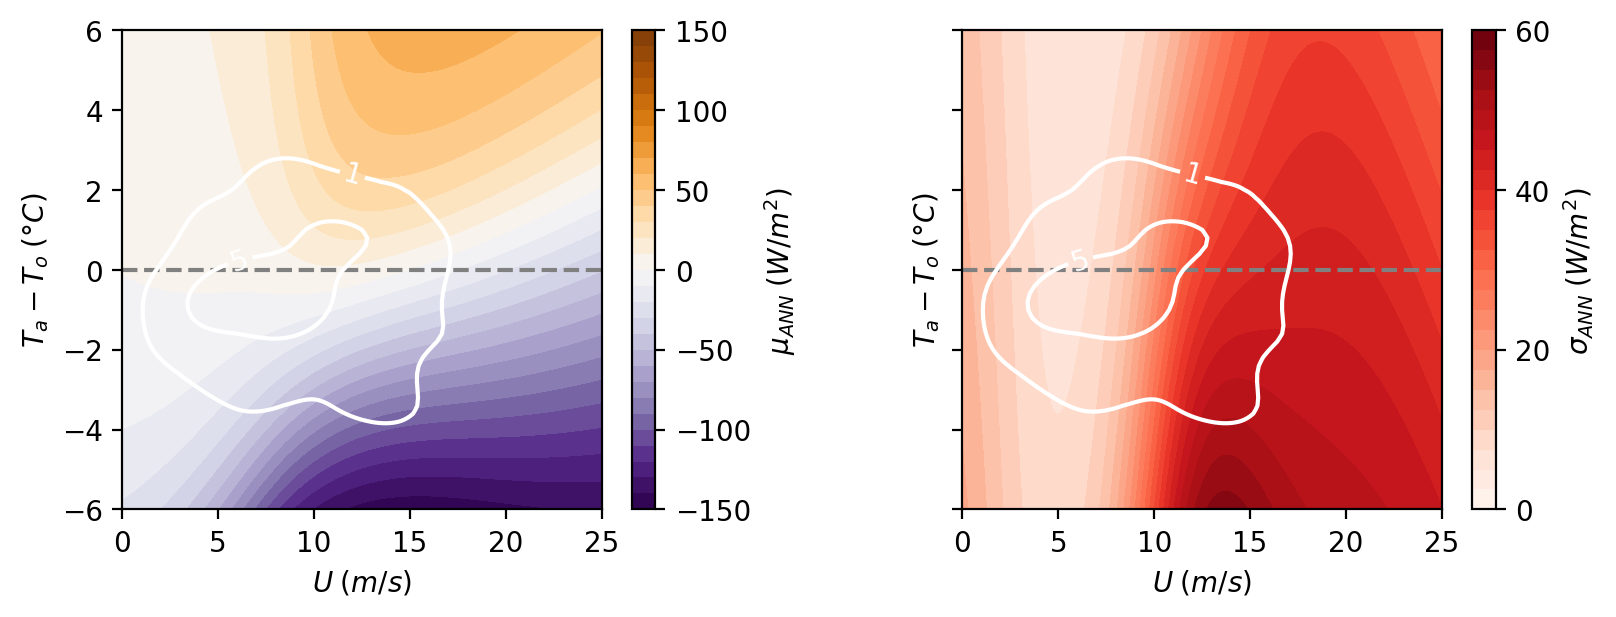

In [46]:
from mlflux.utils import qsat
model_dir = f'/scratch/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'

fig, axes = plt.subplots(1, 2, figsize=[9,4], dpi=200, sharey=True)

rand_seed = 4
model_name = 'model_rand%g.p' %rand_seed
model = open_case (model_dir, model_name)
Xgrid, mean_grid, std_grid = gen_grid (model)

ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
U = Xgrid[:,:,0]
Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]

ax = axes[0]
img_mean = ax.contourf(U, Tdiff, mean_grid, levels=np.arange(-150,155,10), cmap='PuOr_r')
# img = plt.contourf(U, Ta-To, std_2D, levels=np.arange(0,200,5), cmap='Reds')
plt.colorbar(img_mean, label=r'$\mu_{ANN} \; (W/m^2)$', ticks=[-150,-100,-50,0,50,100,150])
ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
ax.set_xlim([0,25]); ax.set_ylim([-6,6])
ax.axhline(y=0, color='gray', linestyle='--')
mean_2D_ensem.append(mean_grid)
plot_data_density (ax, ds, Xgrid) 

ax = axes[1]
# img = ax.contourf(U, Tdiff, np.log(std_grid), levels=np.arange(1,6.5,0.5), cmap='Reds')
img_std = ax.contourf(U, Tdiff, std_grid, levels=np.arange(0,61,2.5), cmap='Reds')
plt.colorbar(img_std, label=r'$\sigma_{ANN} \; (W/m^2)$', ticks=[0,20,40,60])
ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
ax.set_xlim([0,25]); ax.set_ylim([-6,6])
ax.axhline(y=0, color='gray', linestyle='--')
std_2D_ensem.append(std_grid)
plot_data_density (ax, ds, Xgrid)        
   
plt.tight_layout(pad=4)
fig.savefig(f'../../plots/structure.png', bbox_inches='tight')

### Mean of ensemble of ANNs

/state/partition1/job-52435259/ipykernel_2025790/1476758937.py:46: UserWarning: The following kwargs were not used by contour: 'fill'
  contour = ax.contour(U, Tdiff, zi, levels=levels, fill=False, colors='w')  # Filled contours


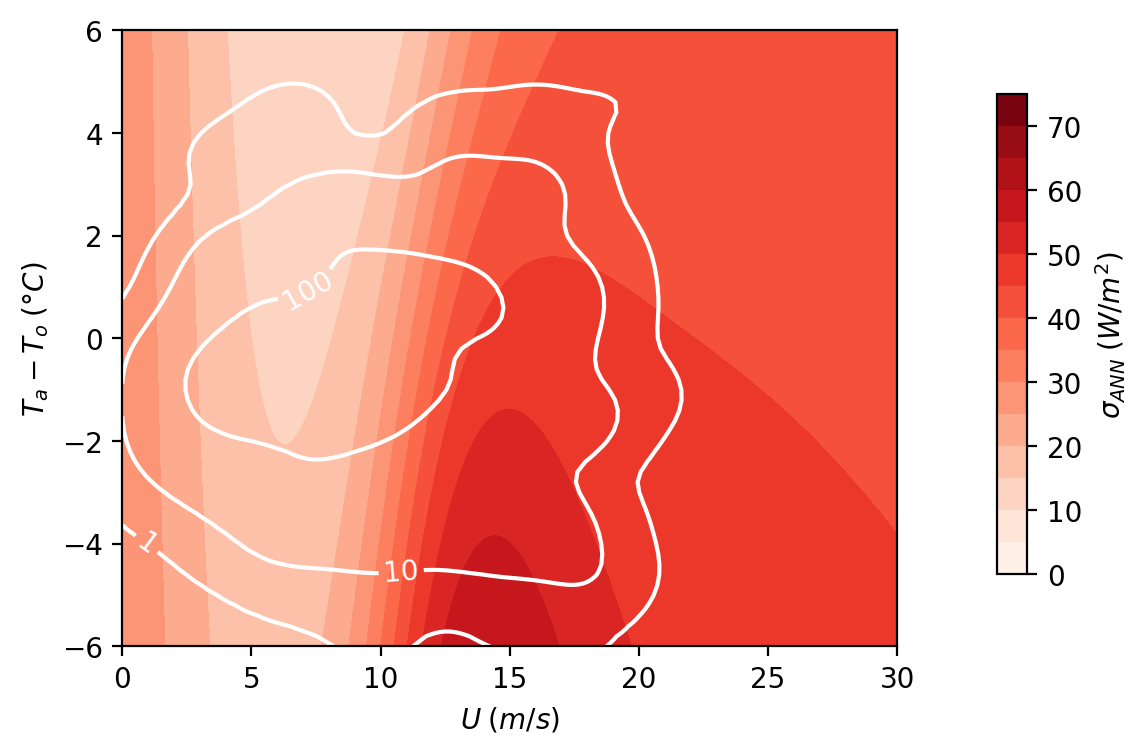

In [4]:
fig = plt.figure(figsize=[5,4], dpi=200); ax = plt.gca()

U = Xgrid[:,:,0]
Tdiff = Xgrid[:,:,2] - Xgrid[:,:,1]
std_ensem = np.array(std_2D_ensem).mean(axis=0)
img = plt.contourf(U, Tdiff, std_ensem, levels=np.arange(0,80,5), cmap='Reds')
ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
ax.set_xlim([0,30]); ax.set_ylim([-6,6])
        
plot_data_density (ax, ds, Xgrid)
cbar_ax = fig.add_axes([1, 0.2, 0.03, 0.6])  # [left, bottom, width, height]
cbar = fig.colorbar(img, cax=cbar_ax, label=r'$\sigma_{ANN}\; (W/m^2)$')

In [ ]:
from mlflux.utils import qsat
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_5/tr5_1step/'
# model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_5/tr5/'
model_dir = f'/home/jw8736/mlflux/saved_model/final/SH5_1/NW_tr2/'
fig, axes = plt.subplots(1, 5, figsize=[15,3], dpi=200, sharey=True)

std_2D_ensem = []
for rand_seed in range(5):
    model_name = 'model_rand%g.p' %rand_seed
    model = open_case (model_dir, model_name)
    ax = axes[rand_seed]
    Xgrid, std_grid = gen_grid (model)

    U = Xgrid[:,:,0]
    RH = Xgrid[:,:,4] 
    img = ax.contourf(U, Tdiff, np.log(std_grid), levels=np.arange(1,6.5,0.5), cmap='Reds')
    # img = plt.contourf(U, Ta-To, std_2D, levels=np.arange(0,200,5), cmap='Reds')
    ax.set_xlabel(r'$U \; (m/s)$'); ax.set_ylabel(r'$T_a - T_o \; (\degree C)$')
    ax.set_xlim([0,30]); ax.set_ylim([-10,10])
    std_2D_ensem.append(std_grid)
        
    ds = xr.load_dataset(model.config['datapath'] + model.config['datafile'])
    plot_data_density (ax, ds, Xgrid)

cbar_ax = fig.add_axes([1, 0.2, 0.01, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(img, cax=cbar_ax, label=r'$\log(\sigma_{ANN}) \; (W/m^2)$')
plt.tight_layout();